Epoch [1/10] - Train MSE: 0.0144
Epoch [2/10] - Train MSE: 0.0101
Epoch [3/10] - Train MSE: 0.0095
Epoch [4/10] - Train MSE: 0.0092
Epoch [5/10] - Train MSE: 0.0090
Epoch [6/10] - Train MSE: 0.0088
Epoch [7/10] - Train MSE: 0.0087
Epoch [8/10] - Train MSE: 0.0087
Epoch [9/10] - Train MSE: 0.0086
Epoch [10/10] - Train MSE: 0.0085
Test MSE: 0.0084


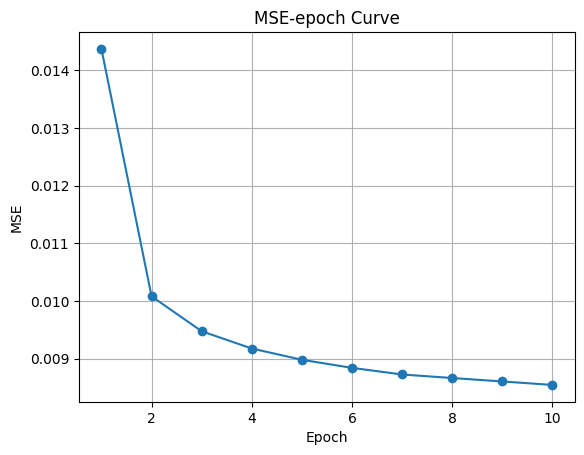

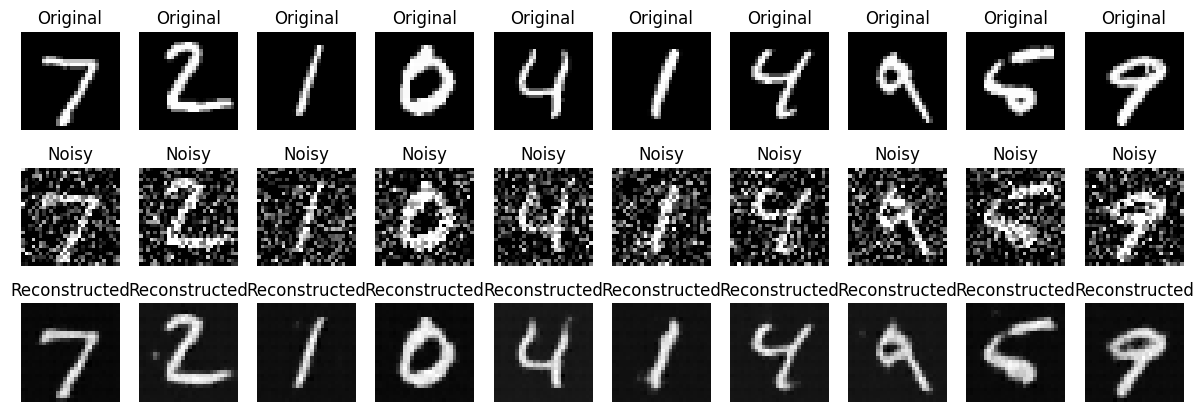

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameters
batch_size = 64
learning_rate = 0.001
num_epochs = 10

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Function to add Gaussian noise to an image
def add_gaussian_noise(image, mean, std_dev):
    noise = torch.randn(image.size()) * std_dev / 255.0
    noisy_image = torch.clamp(image + noise, 0, 1)
    return noisy_image

# Define the Convolutional Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=2, stride=2)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_mse_values = []

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0
    for i, (inputs, _) in enumerate(train_loader):
        noisy_inputs = add_gaussian_noise(inputs, 0, 97)

        optimizer.zero_grad()
        outputs = model(noisy_inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    train_mse = total_loss / len(train_loader)
    train_mse_values.append(train_mse)
    print(f"Epoch [{epoch + 1}/{num_epochs}] - Train MSE: {train_mse:.4f}")

# Plot the MSE-epoch curve
plt.figure()
plt.plot(range(1, num_epochs + 1), train_mse_values, marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title('MSE-epoch Curve')
plt.grid()

model.eval()
test_mse = 0.0

for i, (inputs, _) in enumerate(test_loader):
    noisy_inputs = add_gaussian_noise(inputs, 0, 97)
    outputs = model(noisy_inputs)
    test_mse += criterion(outputs, inputs).item()

test_mse /= len(test_loader)
print(f"Test MSE: {test_mse:.4f}")

fig, axes = plt.subplots(3, 10, figsize=(15, 5))

for i, (inputs, _) in enumerate(test_loader):
    if i >= 10:
        break
    noisy_inputs = add_gaussian_noise(inputs, 0, 97) 
    outputs = model(noisy_inputs)

    axes[0, i].imshow(inputs[0, 0], cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title('Original')

    axes[1, i].imshow(noisy_inputs[0, 0], cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title('Noisy')

    axes[2, i].imshow(outputs[0, 0].detach(), cmap='gray')
    axes[2, i].axis('off')
    axes[2, i].set_title('Reconstructed')
    
plt.show()
